# Example: Pricing of American Options Contracts
We begin our discussion of American style `call` and `put` contracts by computing the premium $\mathcal{P}_{\star}(K,S(0))$ the buyer must pay for a American style-contract at the time its purchased. 

* The key difference between European and American-style contracts is that early exercise is allowed for American-style contracts. Thus, the an Americam contract seller will demand a premium that is greater than the European contract because of the possibility of early exercise (strictly greater than case):

$$\mathcal{P}_{\star}(K,S(0)) \geq \mathbb{E}\Bigl(\mathcal{D}^{-1}_{T,0}(\bar{r})\cdot{V_{\star}}(K,S(T))\Bigr)$$

Because exercise can occur at anytime between $0\rightarrow{T}$ we need to project the share price $S(t)$ over the time interval, not just at the endpoint like a European contract. We'll use a binomial lattice approximation of the share price over the time interval $0\rightarrow{T}$ in combination with a dynamic programming to compute the contract premium.

## Learning objectives
In this example, we'll use the binomial lattice approximation of the share price over the interval $0\rightarrow{T}$ combined with dynamic programming to compute the premium for American-style contracts. In particular, we will focus on how the contract prices change as we move from when the contract was established toward expiration.

* Objective 1: We'll review the pricing of American `call` and `put` contracts using the Cox, Ross, and Rubinstein (CRR) model and [VLQuantitativeFinancePackage.jl](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git)

## Setup

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-5660-Examples-F23`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Manifest.toml`


### Types

The `MyAmericanPutContractModel` and `MyAmericanCallContractModel` types encode information about American `put` and `call` contracts:
* The field `K::Float64` is the strike price of the `put` (or `call`) contract
* The field `sense::Int64` encodes if the contract was sold (`sense = -1` short) or purcahsed (`sense = 1` long). 
* The `DTE::Float64` field encodes the number of days to expiration (DTE) of the contract
* The `IV::Float64` field encodes the implied volatility, i.e., the share price volatility of the underlying asset for this `put` or `call` contract
* The `premium::Union{Nothing, Float64}` field is the cost of the contract (what we'll be calculating in this example)
* The `ticker::Union{Nothing,String}` field encodes the symbol for a `put` or `call` contract, see [How to Read a Stock Options Ticker](https://polygon.io/blog/how-to-read-a-stock-options-ticker/).


The `MyAdjacencyBasedCRREquityPriceTree` type encoded data required to compute the price of an American `call` or `put` contract price using the Bionomial lattice model of Cox, Ross and Rubinstein:
* The `data::Dict{Int, MyCRRLatticeNodeModel}` field holds a `Dict` where the node indexes are the `keys` and `MyCRRLatticeNodeModel` are the values. 
    * The `MyCRRLatticeNodeModel` type holds the `price` and `probability` of the underlying share price, along with the `intrinsic::Float64` and `extrinsic::Float64` value of the contract at the node index. 
* The `connectivity::Dict{Int64, Array{Int64,1}}` holds a `Dict` which holds connectivity information about the nodes in the lattice
* The `levels::Dict{Int64,Array{Int64,1}}` field the node indexes on a particular tree level
* The `u::Float64` field holds the value of the `up` factor
* The `p::Float64` field holds the probability of an `up` price move by the underlying stock
* The `ΔT::Float64` field holds the length of the time step in the lattice
* The `μ::Float64` field holds the risk free growth rate

### Data
We downloaded the options chain for [Advanced Micro Devices (AMD)](https://en.wikipedia.org/wiki/AMD) from [barchart.com](https://www.barchart.com). For this set of values, the share price of `AMD` was $S_{\circ}$ = 117.50 USD/share, and the average implied volatility for `AMD` options with `DTE = 31 days` is `IV = 51.75%`. We load the options data using the ` MyOptionsChainDataSet()` function and store in the `options_dataset` variable, which is an instance of `DataFrame`:

In [2]:
options_dataset = MyOptionsChainDataSet();

## Lattice model of Cox, Ross and Rubinstein (CRR)
A binomial lattice model assumes that each discrete time increment, the state of the system, e.g., the share price of equity, the spot rate, etc., can either increase by a factor $u$ with probability $p$ or decrease by a factor $d$ with probability $(1-p)$. Different models can be developed for the specific values of the tuple $(u,d,p)$. One particular model is the Cox, Ross, and Rubinstein (CRR) model:

* [Cox, J. C.; Ross, S. A.; Rubinstein, M. (1979). "Option pricing: A simplified approach". Journal of Financial Economics. 7 (3): 229. CiteSeerX 10.1.1.379.7582. doi:10.1016/0304-405X(79)90015-1](https://www.sciencedirect.com/science/article/pii/0304405X79900151?via%3Dihub)

The [CRR binomial lattice model](https://en.wikipedia.org/wiki/Binomial_options_pricing_model) was initially developed for options pricing in 1979. However, one of the critical aspects of estimating an option’s price is calculating the underlying asset’s share price. In the [CRR model](https://en.wikipedia.org/wiki/Binomial_options_pricing_model) model, the `up` and `down` moves are symmetric:

$$ud = 1$$

where the magnitude of an `up` move $u$ is given by:

$$u = \exp(\sigma\sqrt{\Delta{T}})$$

The quantity $\sigma$ denotes a _volatility parameter_, and $\Delta{T}$ represents the time step. The probability $p$ of an `up` move in a [CRR model](https://en.wikipedia.org/wiki/Binomial_options_pricing_model) is given by:

$$p = \frac{\exp(\bar{r}\Delta{T}) - d}{u - d}$$

where $\bar{r}$ denotes a _return parameter_. In the [CRR model](https://en.wikipedia.org/wiki/Binomial_options_pricing_model) model paradigm, the return parameter $\mu$ and the volatility parameter $\sigma$ take on common values:
* The return parameter is a _risk-free_ rate of return; the _risk-free_ rate $\bar{r}$ can be approximated by the [yield on T = 10-year United States Treasury debt security](https://ycharts.com/indicators/10_year_treasury_rate). 
* The volatility parameter $\sigma$ is the [implied volatility](https://www.investopedia.com/terms/i/iv.asp); the implied volatility is the market's view of the likelihood of changes in a given security's price.

To start this calculation, first, let's look at how to construct and price a single `put` contract. 
* Let's set constant values for the contracts (these values, with the exception of `IV` are the same for each strike price `K`). The time will be calendar days `Δt = 1/365`, the initial share price `Sₒ` is 117.50 USD/share, the days to expiration or `DTE` is `31` days, the annual risk-free rate is `r̄ = 0.0418` and the (average) implied volatility `IV = 51.75%`:

In [3]:
Δt, Sₒ, r̄, IV, K, h = (1.0/365.0), 117.50, 0.0418, 0.5175, 125.0, 365;
DTE = 31.0*Δt;

Next, let's build an instance of the `MyAdjacencyBasedCRREquityPriceTree` type which holds the parameters and data for the binomial price tree using the `build(...)` function. We store this in the `test_treemodel` variable:

In [4]:
test_treemodel = build(MyAdjacencyBasedCRREquityPriceTree, 
    (μ = r̄, T = DTE, σ = IV)) |> (x-> populate(x, Sₒ = Sₒ, h = h));

Now, create an instance of the `MyAmericanPutContractModel` type which holds the data for the contract information using the `build(...)` method. We store this instance in the `test_american_put_contract_model` variable:

In [5]:
test_american_put_contract_model = build(MyAmericanPutContractModel, (
        K = K, sense = 1, copy = 1));

Finally, we can compute the premium for this `put` contract by passing the `test_treemodel` instance (which holds the risk-neutral simulation of the share price) and the `test_american_put_contract_model` instance (holds contract information) to the `premium(...)` function:

In [6]:
P_american_CRR = premium(test_american_put_contract_model, test_treemodel) |> x-> round(x,sigdigits=3)
println("The CRR premium for the American put contract is: $(P_american_CRR) USD/share")

The CRR premium for the American put contract is: 11.4 USD/share


### Check: Is the predicted price the same as the observed price?

In [7]:
check_put_dataset = filter([:Type, :Strike] => (x,y)-> x == "Put" && y == K, options_dataset)

Row,Strike,Bid,Midpoint,Ask,Last,AVGIV,IV,Type
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,String7
1,125,10.95,11.02,11.1,10.9,0.5175,0.5227,Put


In [8]:
ϵ = (check_put_dataset[1,:Midpoint] - P_american_CRR)/(check_put_dataset[1,:Midpoint])*100

-3.4482758620689724

## Does the `CRR` model replicate the Observed Market Price?
Let's use the `CRR model` to simulate the premium of American-style options contracts as a function of the strike price `K`. 

Next, let's create an array of strike prices that are present in the data, we'll store this array in the `strike_price_array` variable:

In [9]:
start_strike = 40.0;
stop_strike = 200.0;
strike_price_array = range(start_strike, stop = stop_strike, step=1) |> collect;
number_of_strike_prices = length(strike_price_array);

Now that we have the strike prices, and other data we create instances of the `MyAmericanPutContractModel` and `MyAmericanCallContractModel` models which holds the contract data using the `build(...)` method. We store these instances in the `american_put_contract_model` and the `american_call_contract_model` variables:

In [10]:
american_put_contract_model = build(MyAmericanPutContractModel, (
        K = 0.0, sense = 1, copy = 1));

american_call_contract_model = build(MyAmericanCallContractModel, (
        K = 0.0, sense = 1, copy = 1));

### Call contracts
To start the calculation for `call` contracts, we filter the `options_dataset` and collect the `call` contracts with strike prices in the `strike_price_array`, we store the `call` contract data in the `call_dataset`, which is type `DataFrame`. 

Next, we build an instance of the `MyAdjacencyBasedCRREquityPriceTree` type, which holds the parameters and data for the binomial price tree using the `build(...)` function. We store this in the `treemodel` variable. We then calculate the premium for the various strike prices in the `strike_price_array`, ranging from `K=40` to `K=200`, using a `for` loop, and record the estimated premium in the `df_CRR_call_simulation` DataFrame. For each strike price:
* We first check if the dataset has an existing `IV` value. If there is, we use that `IV` value. Otherwise, we use the `at the money` value for the implied volatility, `IV = 0.5175`. 
* Then, we update the strike price field `K` of the `put_contract_model` instance that we created above with the current strike price value.
* Finally, we calculate the premium for this contract using the `premium(…)` function.

In [11]:
call_dataset = filter([:Type, :Strike] => (x,y)-> x == "Call" && y ∈ strike_price_array, options_dataset);
df_CRR_call_simulation = DataFrame()
for value ∈ strike_price_array
    
    # compute the IV - use average IV is not in dataset
    tmp = call_dataset[call_dataset.Strike .== value, :IV]
    IV_value = IV;
    if (isempty(tmp) == false)
        IV_value = first(tmp);
    end
    
    # build the tree -
    treemodel = build(MyAdjacencyBasedCRREquityPriceTree, 
        (μ = r̄, T = DTE, σ = first(IV_value))) |> (x-> populate(x, Sₒ = Sₒ, h = h));
        
    american_call_contract_model.K = value;   
    price_value = premium(american_call_contract_model, treemodel)

    # store the results
    results_tuple = (
        K = value,
        premium = price_value,
        Type = "Call"
    );
    push!(df_CRR_call_simulation, results_tuple);
end

### Put contracts
To start the calculation for `put` contracts, we filter the `options_dataset` and collect the `put` contracts with strike prices in the `strike_price_array`, we store the `put` contract data in the `put_dataset`, which is type `DataFrame`. 

Next, we build an instance of the `MyAdjacencyBasedCRREquityPriceTree` type, which holds the parameters and data for the binomial price tree using the `build(...)` function. We store this in the `treemodel` variable. We then calculate the premium for the various strike prices in the `strike_price_array`, ranging from `K=40` to `K=200`, using a `for` loop, and record the estimated premium in the `df_CRR_put_simulation` DataFrame. For each strike price:
* We first check if the dataset has an existing `IV` value. If there is, we use that `IV` value. Otherwise, we use the average value for the implied volatility, `IV = 0.5175`. 
* Then, we update the strike price field `K` of the `put_contract_model` instance that we created above with the current strike price value. 
* Finally, we calculate the premium for this contract using the `premium(…)` function.* We first check if the dataset has an existing `IV` value. If there is, we use that `IV` value. Otherwise, we use the average value for the implied volatility, `IV = 0.5175`. 

In [12]:
put_dataset = filter([:Type, :Strike] => (x,y)-> x == "Put" && y ∈ strike_price_array, options_dataset);
df_CRR_put_simulation = DataFrame()
for value ∈ strike_price_array
    
    # compute the IV - use average IV is not in dataset
    tmp = put_dataset[put_dataset.Strike .== value, :IV]
    IV_value = IV;
    if (isempty(tmp) == false)
        IV_value = first(tmp);
    end
    
    # build the tree -
    treemodel = build(MyAdjacencyBasedCRREquityPriceTree, 
        (μ = r̄, T = DTE, σ = first(IV_value))) |> (x-> populate(x, Sₒ = Sₒ, h = h));
    
    american_put_contract_model.K = value;   
    price_value = premium(american_put_contract_model, treemodel)

    # store the results
    results_tuple = (
        K = value,
        premium = price_value,
        Type = "Put",
        
    );
    push!(df_CRR_put_simulation, results_tuple);
end

In [13]:
df_CRR_put_simulation

Row,K,premium,Type
,Float64,Float64,String
1,40.0,2.7758e-13,Put
2,41.0,9.67881e-13,Put
3,42.0,3.37272e-12,Put
4,43.0,1.03865e-11,Put
5,44.0,3.23195e-11,Put
6,45.0,9.20726e-11,Put
7,46.0,2.48296e-10,Put
8,47.0,6.74999e-10,Put
9,48.0,1.66124e-9,Put


#### Visualize
Let's plot the strike price `K` on the horizontal axis and the estimated premium on the vertical axis. 
* The CRR option price simulation follows the trend of prices of `put` options that are `at the money`, i.e., when $S\simeq{K}$. Additionally, it captures the prices for contracts `in the money`, i.e., $S \ll {K}$ and `out of the money`, i.e., $S\gg{K}$:
* The CRR option price simulation follows the trend of prices of `call` options that are `at the money`, i.e., when $S\simeq{K}$. However, it under-predicts the prices of contracts `in the money`, i.e., $S \gg {K}$ and `out of the money`, i.e., $S\ll{K}$:

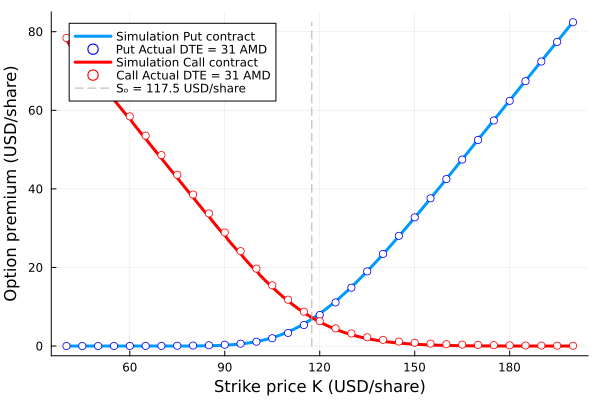

In [14]:
plot(df_CRR_put_simulation[:,1],df_CRR_put_simulation[:,2], lw=3, label="Simulation Put contract")
scatter!(put_dataset[:,:Strike], put_dataset[:,:Ask],label="Put Actual DTE = 31 AMD", mc=:white, msc=:blue)
plot!(df_CRR_call_simulation[:,1],df_CRR_call_simulation[:,2], lw=3, label="Simulation Call contract", c=:red)
scatter!(call_dataset[:,:Strike], call_dataset[:,:Ask],label="Call Actual DTE = 31 AMD", mc=:white, msc=:red)

VLINE = Array{Float64,2}(undef, number_of_strike_prices, 2);
premium_low = 0.0
premium_high = maximum(put_dataset[:,:Ask]);
tmp = range(premium_low, premium_high, length = number_of_strike_prices) |> collect;
for i ∈ 1:number_of_strike_prices
    VLINE[i,1] = Sₒ
    VLINE[i,2] = tmp[i]
end
plot!(VLINE[:,1], VLINE[:,2], c=:gray69, ls=:dash, label="Sₒ = $(Sₒ) USD/share")

xlabel!("Strike price K (USD/share)", fontsize=18)
ylabel!("Option premium (USD/share)", fontsize=18)